<a href="https://colab.research.google.com/github/A-Marambe/Land_surface_temperature/blob/master/Default_Warning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# data manipulation imports
import pandas as pd
import geopandas as gpd
import gdal
from matplotlib import pyplot as plt

# system imports
import os
import glob

,district,geometry
0,[unknown],"POLYGON ((79.80303 7.85030, 79.80333 7.84946, ..."
1,Ampara,"POLYGON ((81.23892 7.73850, 81.23903 7.73846, ..."
2,Anuradhapura,"POLYGON ((80.79126 8.91877, 80.79164 8.91876, ..."
3,Badulla,"POLYGON ((80.98060 7.61768, 80.98104 7.61765, ..."
4,Batticaloa,"MULTIPOLYGON (((81.76936 7.53607, 81.76918 7.5..."


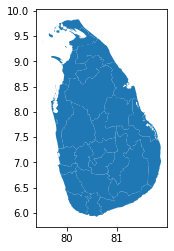

In [0]:
# import distric map
district_poly_list = glob.glob(".\\input_shapes\\*.shp")

district_lateset = max(district_poly_list, key=os.path.getctime)

# read district poly
district_lateset = gpd.read_file(district_lateset)
district_lateset = district_lateset[['ADM2_EN', 'geometry']]

# select and rename columns
district_lateset.columns = ['district', 'geometry']
district_lateset.head()
district_lateset.plot()
district_lateset.head()

In [0]:
# weather feed lateset
weather_data_list =  glob.glob(".\\weather_feed\\*.csv")
latest_precep = max(weather_data_list, key=os.path.getctime)
weather_source = pd.read_csv(latest_precep)
weather_source = weather_source[['date', 'precep(mm)','lon','lat']]
weather_source

,date,precep(mm),lon,lat
0,2020-06-07,100.0,80.6337,7.2906
1,2020-06-07,150.0,80.6234,7.4670
2,2020-06-07,20.0,80.3464,7.2513


In [0]:
# weather data convert to gdf
rain_gdf = gpd.GeoDataFrame(weather_source, geometry=gpd.points_from_xy(weather_source.lon, weather_source.lat))
rain_gdf = rain_gdf[['date','precep(mm)', 'geometry']]
rain_gdf.columns = ['date','precep', 'geometry']

# change CRS to same


rain_gdf

,date,precep,geometry
0,2020-06-07,100.0,POINT (80.63370 7.29060)
1,2020-06-07,150.0,POINT (80.62340 7.46700)
2,2020-06-07,20.0,POINT (80.34640 7.25130)


In [0]:
# drop by index :: rains lower than 50 mm

# do intersection
rain_obs = gpd.sjoin(district_lateset, rain_gdf, how="inner", op='contains')
rain_obs



C:\Users\User\Anaconda3\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:4326'} != None)
  "(%s != %s)" % (left_df.crs, right_df.crs)


,district,geometry,index_right,date,precep
11,Kandy,"POLYGON ((80.95625 7.48809, 80.95647 7.48787, ...",0,2020-06-07,100.0
12,Kegalle,"MULTIPOLYGON (((80.15908 7.19821, 80.15877 7.1...",2,2020-06-07,20.0
16,Matale,"POLYGON ((80.75750 8.00496, 80.75923 8.00364, ...",1,2020-06-07,150.0


In [0]:
# creating a column to risk level

rain_obs.loc[(rain_obs.precep>125),'risk_level']= "high"
rain_obs.loc[(rain_obs.precep>75) & (rain_obs.precep<125), 'risk_level']= "medium"
rain_obs.loc[(rain_obs.precep<75) & (rain_obs.precep>50), 'risk_level']= "low"


In [0]:
# drop NaN  risks
risk_table = rain_obs.dropna(how='any')

# color assignment
risk_table.loc[(risk_table.risk_level=='medium'),'risk_color']= 'y'
risk_table.loc[(risk_table.risk_level=='high'),'risk_color']= 'r'

# colors to list
rsk_colors = list(risk_table['risk_color'])
risk_table

C:\Users\User\Anaconda3\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\User\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,district,geometry,index_right,date,precep,risk_level,risk_color
11,Kandy,"POLYGON ((80.95625 7.48809, 80.95647 7.48787, ...",0,2020-06-07,100.0,medium,y
16,Matale,"POLYGON ((80.75750 8.00496, 80.75923 8.00364, ...",1,2020-06-07,150.0,high,r


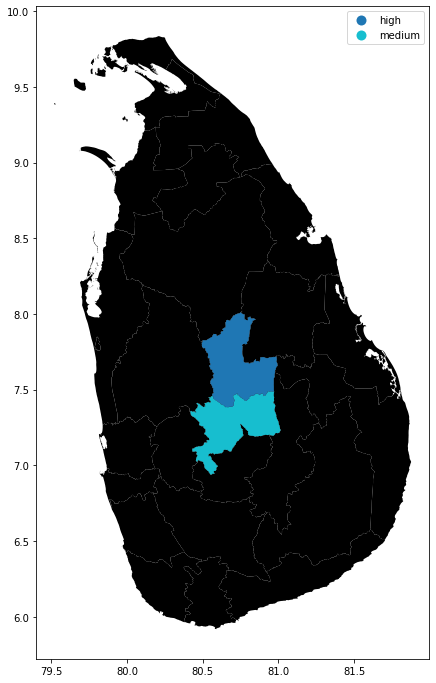

In [0]:
fig, ax = plt.subplots(figsize=(8, 12))
#district_lateset.plot(facecolor=(0.1843, 0.3098, 0.3098), ax=ax)
district_lateset.plot(facecolor='k', ax=ax)
risk_table.plot(column='risk_level', legend=True, ax= ax)

In [0]:
# Email the risk level
